In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
img_size = 28
hidden_dim = 256
latent_dim = 3
class Encoder(nn.Module):
    def __init__(self, x_dim=img_size**2, h_dim=hidden_dim, z_dim=latent_dim):
        super(Encoder, self).__init__()

        # 1st hidden layer
        self.fc1 = nn.Sequential(
            nn.Linear(x_dim, h_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2)
        )

        # 2nd hidden layer
        self.fc2 = nn.Sequential(
            nn.Linear(h_dim, h_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2)
        )

        # output layer
        self.mu = nn.Linear(h_dim, z_dim)
        self.logvar = nn.Linear(h_dim, z_dim)

    def forward(self, x):
        x = self.fc2(self.fc1(x))

        mu = F.relu(self.mu(x))
        logvar = F.relu(self.logvar(x))

        z = reparameterization(mu, logvar)
        return z, mu, logvar

In [2]:
def reparameterization(mu, logvar):
    std = torch.exp(logvar/2)
    eps = torch.randn_like(std)
    return mu + eps * std

In [3]:
class Decoder(nn.Module):
    def __init__(self, x_dim=img_size**2, h_dim=hidden_dim, z_dim=latent_dim):
        super(Decoder, self).__init__()

        # 1st hidden layer
        self.fc1 = nn.Sequential(
            nn.Linear(z_dim, h_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2),
        )

        # 2nd hidden layer
        self.fc2 = nn.Sequential(
            nn.Linear(h_dim, h_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2)
        )

        # output layer
        self.fc3 = nn.Linear(h_dim, x_dim)

    def forward(self, z):
        z = self.fc2(self.fc1(z))
        x_reconst = F.sigmoid(self.fc3(z))
        return x_reconst

In [4]:
# mnist dataset
import numpy as np
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml


import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from matplotlib import pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Current cuda device is', device)

batch_size = 50
learning_rate = 0.0001
epoch_num = 15

train_data = datasets.MNIST(root = '../data/mnist/',
                            train=True,
                            download=True,
                            transform=transforms.ToTensor())
test_data = datasets.MNIST(root = '../data/mnist/',
                            train=False,
                            download=True,
                            transform=transforms.ToTensor())
print('number of training data : ', len(train_data))
print('number of test data : ', len(test_data))

tf = transforms.ToTensor()
train = datasets.MNIST(root = '../data/mnist/',
                            train=True,
                            download=True,
                            transform=tf)

test = datasets.MNIST(root = '../data/mnist/',
                            train=False,
                            download=True,
                            transform=tf)

Current cuda device is cuda
number of training data :  60000
number of test data :  10000


In [5]:
n_epochs = 20
batch_size = 128
train_dataloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True,)
encoder = Encoder().to(device)
decoder = Decoder().to(device)
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)

logger = {}
logger['train_loss'] = []
logger['test_loss'] = []
logger['kl_div'] = []
for epoch in range(n_epochs):
    for i, (x, _) in enumerate(train_dataloader):
        # forward
        x = x.view(-1, img_size**2)
        x = x.to(device)
        z, mu, logvar = encoder(x)
        x_reconst = decoder(z)

        # compute reconstruction loss and KL divergence
        reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
        kl_div = 0.5 * torch.sum(mu.pow(2) + logvar.exp() - logvar - 1)

        # backprop and optimize
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('Epoch [{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}'.format(epoch+1, n_epochs, i+1, len(train_dataloader), reconst_loss.item(), kl_div.item()))
    logger['train_loss'].append(loss.item())
    logger['test_loss'].append(loss.item())
    logger['kl_div'].append(kl_div.item())
        
        

Epoch [1/20], Step [469/469], Reconst Loss: 20209.3984, KL Div: 135.1806
Epoch [2/20], Step [469/469], Reconst Loss: 19311.4082, KL Div: 225.7565
Epoch [3/20], Step [469/469], Reconst Loss: 18743.9492, KL Div: 250.0045
Epoch [4/20], Step [469/469], Reconst Loss: 18500.9336, KL Div: 361.4466
Epoch [5/20], Step [469/469], Reconst Loss: 19025.2676, KL Div: 339.9226
Epoch [6/20], Step [469/469], Reconst Loss: 19016.6973, KL Div: 335.9265
Epoch [7/20], Step [469/469], Reconst Loss: 17532.1992, KL Div: 546.3389
Epoch [8/20], Step [469/469], Reconst Loss: 17784.2285, KL Div: 457.3685
Epoch [9/20], Step [469/469], Reconst Loss: 18443.1680, KL Div: 452.0883
Epoch [10/20], Step [469/469], Reconst Loss: 17833.1602, KL Div: 568.3876
Epoch [11/20], Step [469/469], Reconst Loss: 18295.9375, KL Div: 598.2324
Epoch [12/20], Step [469/469], Reconst Loss: 17055.3848, KL Div: 725.0271
Epoch [13/20], Step [469/469], Reconst Loss: 18227.4961, KL Div: 558.0985
Epoch [14/20], Step [469/469], Reconst Loss: 17

(1, 3)
torch.Size([1, 784])
(1, 3)
torch.Size([1, 784])
(1, 3)
torch.Size([1, 784])
(1, 3)
torch.Size([1, 784])
(1, 3)
torch.Size([1, 784])
(1, 3)
torch.Size([1, 784])


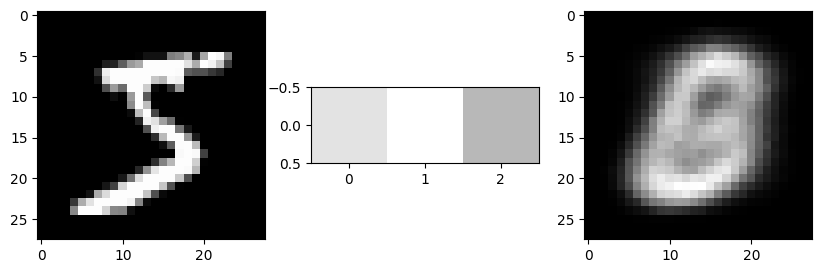

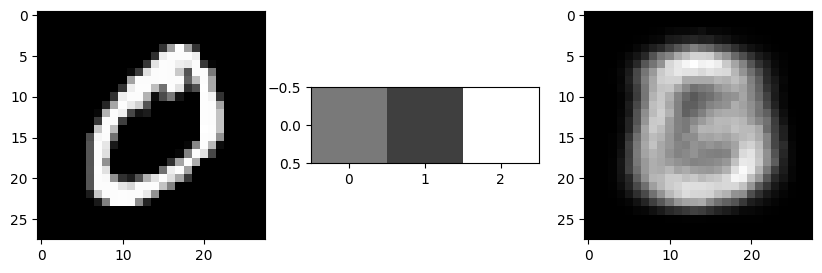

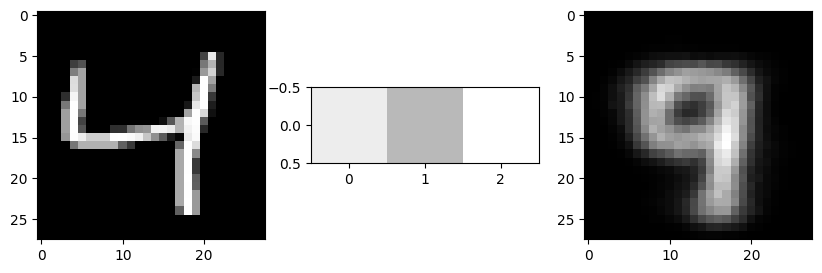

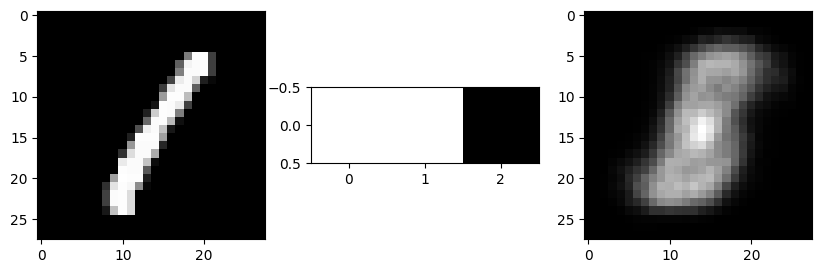

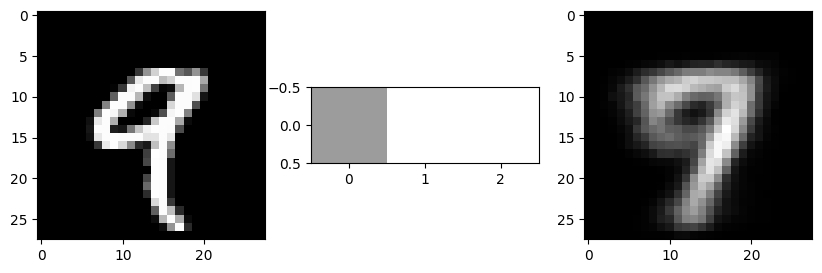

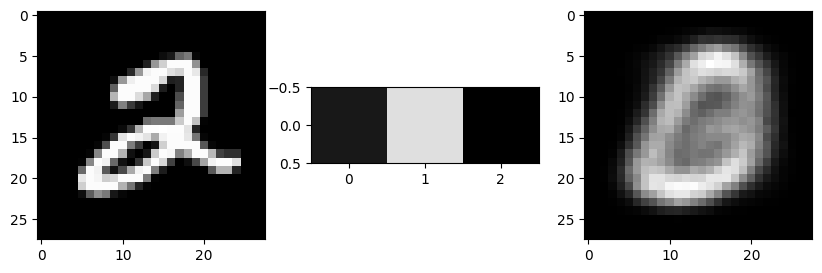

In [6]:
for i in range(0,6):
    x = train[i][0].view(-1, img_size**2)
    x = x.to(device)

    z,a,b = encoder(x)
    g = decoder(z)

    z = z.cpu().detach().numpy()
    print(z.shape)

    # g = decoder(z)

    
    print(g.shape)
    g = g.cpu().detach().numpy().reshape(28,28)
    plt.figure(figsize=(10,5))
    plt.subplot(1,3,1)
    plt.imshow(train[i][0].reshape(28,28),cmap='gray')
    plt.subplot(1,3,2)
    plt.imshow(z,cmap='gray',vmin=-1,vmax=1)
    plt.subplot(1,3,3)
    plt.imshow(g,cmap='gray')

In [7]:
zs = []
for i in range(0,1000):
    x = train[i][0].view(-1, img_size**2)
    x = x.to(device)

    z,a,b = encoder(x)
    g = decoder(z)

    z = z.cpu().detach().numpy()
    zs.append(z)
type(zs[0])

zs = np.array(zs)
zs = zs.reshape(3000,latent_dim)
zs.shape

(3000, 3)

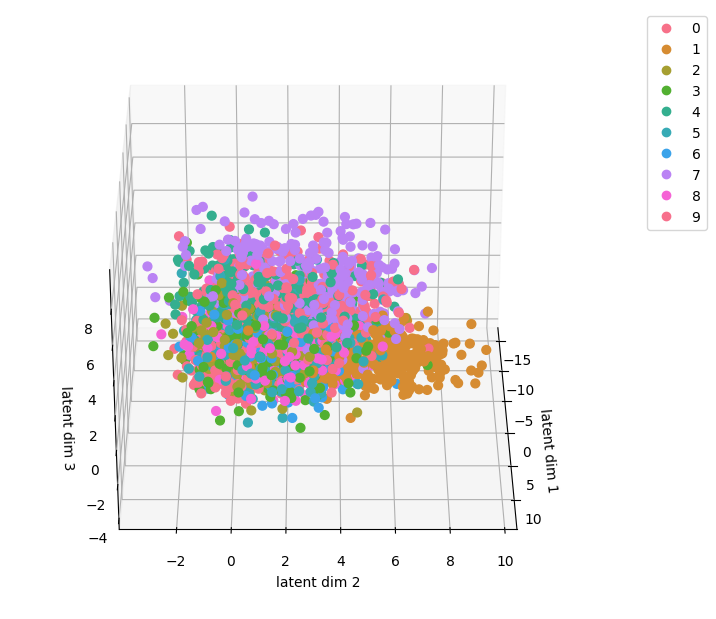

In [8]:
import re, seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D


import numpy as np

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

# generate data
x = zs[:,0]
y = zs[:,1]
z = zs[:,2]
# change the label to int
label = train.targets[:3000].numpy()

# axes instance
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

# plot
sc = ax.scatter(x, y, z, s=40, c=label, marker='o', cmap=cmap, alpha=1)
ax.set_xlabel('latent dim 1')
ax.set_ylabel('latent dim 2')
ax.set_zlabel('latent dim 3')

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# save
plt.savefig("scatter_hue", bbox_inches='tight')

from matplotlib import animation

def rotate(angle):
    ax.view_init(azim=angle)

angle = 3
ani = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 360, angle), interval=10)
ani.save('vae_3point.gif', writer=animation.PillowWriter(fps=60))